기본 신경망 학습
Pytorch를 사용해 신경망을 학습하는 것을 익히기 위한 자료입니다
MNIST 데이터 학습을 위한 신경망 학습
MNIST는 손글씨의 숫자 (0~9)를 분류하는 문제를 위한 데이터입니다.

In [ ]:
import torch
import torch.nn as nn ## linear, other operation
import torch.nn.functional as F ## 다양한 activation 함수
import torchvision
import torchvision.datasets as vision_dsets
import torchvision.transforms as T
import torch.optim as optim

from torch.autograd import Variable
from torch.utils import data

In [ ]:
## 데이터 분석을 위한 library의 import
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
  accuracy = np.trace(cm) / float(np.sum(cm)) ## trace : matrix의 diagonal term의 summation / matrix의 모든 element의 합
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(20,15))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  thresh = cm.max() / 1.5 if normalize else cm.max() /2

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    if labels:
      for i, j in itertools.product(range(cm.shape[0], range(cm.shape[1]))):
        if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
          plt.text(j, i, "{:,}".format(cm[i,j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black" )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

DataLoader의 생성
MNIST Data의 경우 Pytorch의 torchvision에 있는 데이터 셋을 받아 옴

In [ ]:
def MNIST_DATA(root='./data',transforms=None, download=True, batch_size=32, num_worker=4): ## num_worker = cpu 수
  print("Get the MNIST Data")

  mnist_train = vision_dsets.MNIST(root=root, train=True, transform = T.ToTensor(), download=download) ## train 셋 형태는 Tensor 형태로
  mnist_test = vision_dsets.MNIST(root = root, train=False, transform = T.ToTensor(), download = download) ## 테스트 셋

  trainDataLoader = data.DataLoader(dataset = mnist_train, batch_size = batch_size, shuffle = True, num_workers = num_worker)## PyTorch의 DataLoader를 사용하여 훈련 데이터셋을 미니배치로 나누고, 데이터를 모델에 공급할 수 있는 iterator를 생성.
  testDataLoader = data.DataLoader(dataset = mnist_test, batch_size = batch_size, shuffle = False, num_workers = num_worker) ## barch_size = 한 번에 모델에 입력될 데이터 수

  print("[+] Finished loading data & Preprocessing")
  return mnist_train, mnist_test,trainDataLoader,testDataLoader

In [ ]:
trainDset, testDset, trainDataLoader, testDataLoader = MNIST_DATA(batch_size = 32) # Data Loader

Get the MNIST Data
[+] Finished loading data & Preprocessing


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
trainDset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

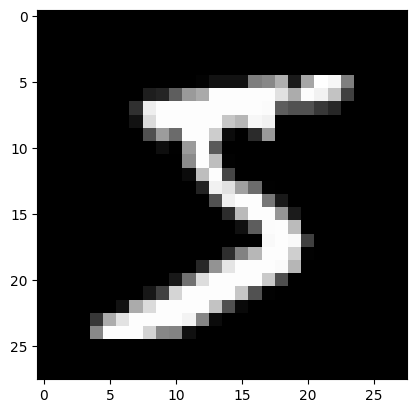

In [ ]:
plt.imshow(trainDset.data[0], cmap='gray')

Trainer를 class로 만든 것입니다. 목적은 ent, trainloader, testloader, optimizer,criterion을 모두 input으로 받아, Trainer 내에서 모델의 학습과 평가를 하기 위함

In [ ]:
data = next(iter(trainDataLoader))
print(data[0].shape) ## 32, 1, 28, 28 미니배치 사이즈, 이미지 채널(흑백), 이미지의 높이, 이미지의 넓이

torch.Size([32, 1, 28, 28])


In [ ]:
class Trainer():
  def __init__(self, trainloader, testloader, net, optimizer, criterion): ## criterion == loss functioin
    self.trainloader = trainloader
    self.testloader = testloader
    self.net = net
    self.optimizer = optimizer ## optimizer = optimizer to update your model
    self.criterion = criterion

  def train(self, epoch = 100):
    self.net.train() ## net 학습 모드
    for e in range(epoch): ##epoch만큼 train한다.
      running_loss = 0.0
      for i, data in enumerate(self.trainloader, 0):
        inputs, labels = data[0], data[1]
        inputs = inputs.cuda() ## 불러온 데이터를 GPU위에 올리기
        labels = labels.cuda()

        self.optimizer.zero_grad()

        outputs = self.net(inputs)
        loss = self.criterion(outputs, labels) ## 손실 계산
        loss.backward() ## 손실 함수에 대한 각 파라미터의 기울기 계산
        self.optimizer.step() ## 모델의 파라미터를 업데이트

        running_loss += loss.item() ## 현재의 손실 값 계산
        if(i+1) % 500 == 0:
          print('[%d, %5d] loss: %.3f' % (e+1, i+1, running_loss/500))
          running_loss = 0.0
    print('Finished Trainning')

  def test(self):
    self.net.eval()

    test_loss = 0
    correct = 0
    for inputs, labels in self.testloader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      output = self.net(inputs)  # test 데이터를 넣어 예측 값을 구하는 함수
      pred = output.max(1, keepdim=True)[1] ## 확률이 가장 높은 거 추출
      correct += pred.eq(labels.view_as(pred)).sum().item() ##  예측된 클래스와 실제 클래스가 일치하는 경우를 세는 과정을 나타냅니다.

      test_loss /= len(self.testloader.dataset) ## 10,000
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.
          format(correct, len(self.testloader.dataset),
                  100.*correct/len(self.testloader.dataset)))

  def get_conf(self): ## 모델의 예측 결과를 평가하고, 혼동 행렬(confusion matrix)을 계산 (각 수에대한 에러 평가)
    self.net.eval() ## 평가 모드

    confusion = torch.zeros(10, 10)
    for inputs, labels in self.testloader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      output = self.net(inputs)
      pred = torch.argmax(output, dim=1)

      for num in range(output.shape[0]):
        confusion[pred[num], labels[num]] += 1
    return confusion




2 Layer Network + Sigmoid


*   input: (28 * 28)
*   Hidden dimension: 30
*   Output dimension: 10
*   activation: sigmoid
*   Optimizer: SGD
*   Loss: Cross-Entropy


In [ ]:
class MNIST_Net(nn.Module):
  def __init__(self):
    super(MNIST_Net, self).__init__()
    self.fc0 = nn.Linear(28*28,30)
    self.fc1 = nn.Linear(30, 10)
    self.act = nn.Sigmoid()

  def forward(self, x):
    x = x.view(-1, 28*28) ##
    x = self.fc0(x) # 28 * 28 -> 30 ## 첫 번째 층 입력 : 28*28 출력 : 30
    x = self.act(x) # Activation function
    x = self.fc1(x) # 30 -> 10, 출력: 0~9까지의 수
    return x

In [ ]:
mnist_net = MNIST_Net().cuda() ## 인스턴스를 GPU에 올림
criterion = nn.CrossEntropyLoss() ## 손실함수
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) ## 경사 하강법 파라미터를 업데이트하는 데 사용

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion=criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1,   500] loss: 2.082
[1,  1000] loss: 2.060
[1,  1500] loss: 2.037
[2,   500] loss: 2.000
[2,  1000] loss: 1.974
[2,  1500] loss: 1.949
[3,   500] loss: 1.908
[3,  1000] loss: 1.877
[3,  1500] loss: 1.852
[4,   500] loss: 1.802
[4,  1000] loss: 1.773
[4,  1500] loss: 1.749
[5,   500] loss: 1.697
[5,  1000] loss: 1.669
[5,  1500] loss: 1.648
[6,   500] loss: 1.596
[6,  1000] loss: 1.568
[6,  1500] loss: 1.539
[7,   500] loss: 1.498
[7,  1000] loss: 1.472
[7,  1500] loss: 1.448
[8,   500] loss: 1.409
[8,  1000] loss: 1.381
[8,  1500] loss: 1.355
[9,   500] loss: 1.322
[9,  1000] loss: 1.302
[9,  1500] loss: 1.280
[10,   500] loss: 1.248
[10,  1000] loss: 1.227
[10,  1500] loss: 1.207
Finished Trainning


In [ ]:
trainer.test()


Test set: Accuracy: 5957/10000 (60%)



ReLU 사용

In [ ]:
class MNIST_Net(nn.Module):
  def __init__(self):
    super(MNIST_Net, self).__init__()
    self.fc0 = nn.Linear(28*28,30)
    self.fc1 = nn.Linear(30, 10)
    self.act = nn.ReLU()

  def forward(self, x):
    x = x.view(-1, 28*28) ##
    x = self.fc0(x) # 28 * 28 -> 30
    x = self.act(x) # Activation function
    x = self.fc1(x) # 30 -> 10, logit for each class
    return x

In [ ]:
mnist_net = MNIST_Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion=criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[1,   500] loss: 2.253
[1,  1000] loss: 2.157
[1,  1500] loss: 2.040
[2,   500] loss: 1.801
[2,  1000] loss: 1.657
[2,  1500] loss: 1.510
[3,   500] loss: 1.263
[3,  1000] loss: 1.149
[3,  1500] loss: 1.051
[4,   500] loss: 0.910
[4,  1000] loss: 0.850
[4,  1500] loss: 0.808
[5,   500] loss: 0.727
[5,  1000] loss: 0.694
[5,  1500] loss: 0.664
[6,   500] loss: 0.621
[6,  1000] loss: 0.605
[6,  1500] loss: 0.583
[7,   500] loss: 0.555
[7,  1000] loss: 0.551
[7,  1500] loss: 0.533
[8,   500] loss: 0.514
[8,  1000] loss: 0.511
[8,  1500] loss: 0.498
[9,   500] loss: 0.478
[9,  1000] loss: 0.483
[9,  1500] loss: 0.469
[10,   500] loss: 0.454
[10,  1000] loss: 0.455
[10,  1500] loss: 0.443
Finished Trainning


In [ ]:
trainer.test()


Test set: Accuracy: 8883/10000 (89%)

